### Style Transfer

- $P_l$: $l_{th}$ feature map of content photo
- $S_l$: $l_{th}$ feature map of style photo
- $F_l$: $l_{th}$ feature map of generated photo

- Content Loss
$$L_{content}= \frac{1}{2} \sum_{i,j}(F_{ij}^{l}-P_{ij}^{l})^2$$

#### Gram matrix

- The correlations between the different filter responses, where the expectation is taken over the spatial extend of the input image. 
- Gram matrix $G^l \in \mathcal{R}^{N_{l} \times N_{l}}$, where $N_{l}$ is the number of filters at $l_{th}$ layer.
- n개의 filter가 있으면, $H \times W$의 feature map을 flatten하여 n개의  $HW$ 차원 벡터를 만들고, n개 벡터를 inner product하여 matrix로 구성한다. 
    - Intuition: n개의 filter 중에 동시에 발현되는 filter를 찾는 것. (e.g. 원을 찾는 filter와 빨간색을 찾는 filter로 각각 $HW$ 벡터를 구하고 이를 내적해서 큰 값이 나오면 두 filter의 activation이 유사하다는 것이고, 동시에 나타난 다는 것)

<img src=attachment:image.png width=650><br><center>*[source](https://medium.com/udacity-pytorch-challengers/style-transfer-using-deep-nural-network-and-pytorch-3fae1c2dd73e) </center>
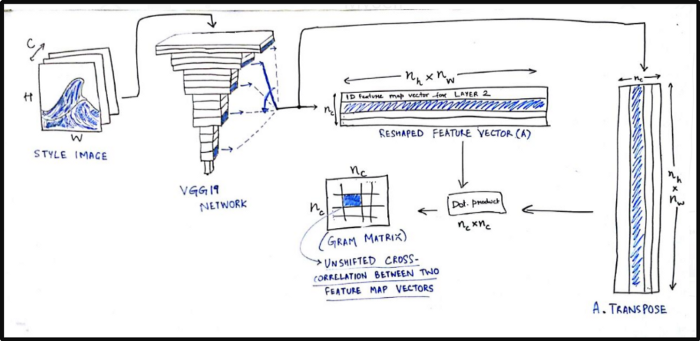

$$G_{ij}^l = \sum_{k \in HW} F_i^l F_j^l  $$
- $G_{ij}^l$ : Inner product between the vectorized feature map $i$ and $j$.
- $F_i$ : Activation of the $i^{th}$ filter
- $F_j$ : Activation of the $j^{th}$ filter

- Style loss in one layer $l$
$$E_l = \frac{1}{4N^2M^2} \sum (G_{ij}^l- A_{ij}^l)^2 $$
- Total style loss 
$$ L_{style} = \sum_{l=0}^{L} w_{l}E_l $$
    - $w_l$: weighting factor of each layer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from torchvision import transforms, models

In [2]:
device = torch.device('cuda:0')

- VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [3]:
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])  # transform it into a torch tensor

In [4]:
picasso = Image.open('./picasso.jpg')
dance = Image.open('./dancing.jpg')

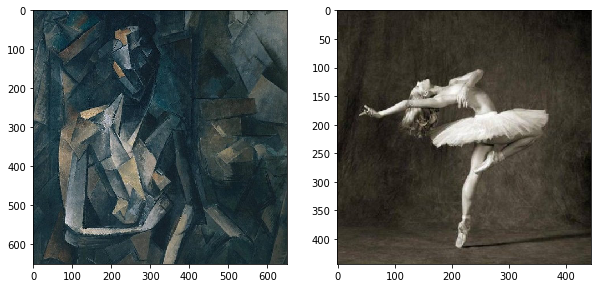

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(picasso)
plt.subplot(1,2,2)
plt.imshow(dance)
plt.show()

In [6]:
def image_loader(image_name):
    image = Image.open(image_name)    
    image = loader(image).unsqueeze(0)  #expand batch dim
    return image.to(device, torch.float)

In [7]:
style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

In [8]:
print(style_img.shape)
print(content_img.shape)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [9]:
def tensor_to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [10]:
vgg = models.vgg19(pretrained=True)

- VGG19 is consists of two parts:
    - vgg19.features (convolutional and pooling layer)
    - vgg19.classifier ( last three layers for output)
- For style transfer we need only features portion ,so we will load in that and freeze the weights.

#### A Little Trick
- The authors propose to replace all max-pooling layers in the network with average pooling for better-looking results. So let's go ahead and do exactly that

In [11]:
for i, layer in enumerate(vgg.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        print(i)

4
9
18
27
36


- We don't compute gradients with respect to our model's weights, but only with respect to our input image tensor.

In [12]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [13]:
vgg.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)
    (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
 

In [14]:
def gram_matrix(tensor):
    _, n_filters, h, w = tensor.size()
    tensor = tensor.view(n_filters, h * w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [15]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1','5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content layer
                  '28': 'conv5_1'}
    features = {}
    x = image
    # enumerate로 numbering 한 것을 layer의 이름으로 활용
    # vgg.features에 있는 모든 layer를 다 통과하면서 원하는 activation만 keep (well done)
    for name, layer in enumerate(model.features):
        x = layer(x)   
        if str(name) in layers:
            features[layers[str(name)]] = x

    return features

In [16]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

In [17]:
for layer in style_features:
    print(layer)

conv1_1
conv2_1
conv3_1
conv4_1
conv4_2
conv5_1


In [18]:
style_features['conv3_1'].shape

torch.Size([1, 256, 128, 128])

In [19]:
gram_matrix(style_features['conv3_1']).shape

torch.Size([256, 256])

In [20]:
style_grams = {
  layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

- Initialize target image
    - requires_grad_ to True, so we can perform gradient descent updates on the image.
    - #target = content_img.clone().requires_grad_(True).to(device) if you want to start from the original content, however, choosing random noise as a starting point will make it easier to juggle the content and style terms.

In [21]:
target = torch.randn_like(content_img).requires_grad_(True).to(device)

In [22]:
content_weight = 1e4
style_weight = 1e2

In [23]:
optimizer = optim.Adam([target], lr=0.01)

In [24]:
num_iteration=7000

for i in range(1, num_iteration + 1):
    optimizer.zero_grad()
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] -
                             content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean(
          (target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()

    if i % 500 == 0:
        total_loss_rounded = round(total_loss.item(), 2)
        content_fraction = round(
          content_weight*content_loss.item()/total_loss.item(), 2)
        style_fraction = round(
          style_weight*style_loss.item()/total_loss.item(), 2)
        print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(
          i,total_loss_rounded, content_fraction, style_fraction))

final_img = tensor_to_image(target)

Iteration 500, Total loss: 1619.32 - (content: 0.14, style 0.86)
Iteration 1000, Total loss: 1027.68 - (content: 0.12, style 0.88)
Iteration 1500, Total loss: 548.09 - (content: 0.16, style 0.84)
Iteration 2000, Total loss: 270.9 - (content: 0.23, style 0.77)
Iteration 2500, Total loss: 146.17 - (content: 0.31, style 0.69)
Iteration 3000, Total loss: 85.59 - (content: 0.38, style 0.62)
Iteration 3500, Total loss: 56.45 - (content: 0.45, style 0.55)
Iteration 4000, Total loss: 41.91 - (content: 0.49, style 0.51)
Iteration 4500, Total loss: 34.06 - (content: 0.52, style 0.48)
Iteration 5000, Total loss: 29.33 - (content: 0.53, style 0.47)
Iteration 5500, Total loss: 26.13 - (content: 0.53, style 0.47)
Iteration 6000, Total loss: 24.2 - (content: 0.54, style 0.46)
Iteration 6500, Total loss: 22.62 - (content: 0.54, style 0.46)
Iteration 7000, Total loss: 21.42 - (content: 0.53, style 0.47)


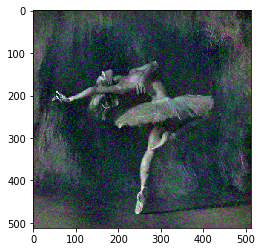

In [25]:
fig = plt.figure()
plt.imshow(final_img)

#### Let's give it another try.

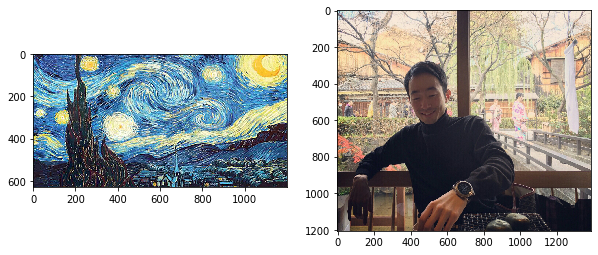

In [26]:
style = Image.open('./starrynight.jpg')
content = Image.open('./mypic.jpg')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(style)
plt.subplot(1,2,2)
plt.imshow(content)
plt.show()

In [27]:
style_img = image_loader("./starrynight.jpg")
content_img = image_loader("./mypic.jpg")

In [28]:
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [29]:
target = torch.randn_like(content_img).requires_grad_(True).to(device)
optimizer = optim.Adam([target], lr=0.01)

In [30]:
num_iteration=7000

for i in range(1, num_iteration + 1):
    optimizer.zero_grad()
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] -
                             content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean(
          (target_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()

    if i % 500 == 0:
        total_loss_rounded = round(total_loss.item(), 2)
        content_fraction = round(
          content_weight*content_loss.item()/total_loss.item(), 2)
        style_fraction = round(
          style_weight*style_loss.item()/total_loss.item(), 2)
        print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(
          i,total_loss_rounded, content_fraction, style_fraction))

final_img = tensor_to_image(target)

Iteration 500, Total loss: 2073.05 - (content: 0.66, style 0.34)
Iteration 1000, Total loss: 1049.67 - (content: 0.65, style 0.35)
Iteration 1500, Total loss: 681.27 - (content: 0.66, style 0.34)
Iteration 2000, Total loss: 488.95 - (content: 0.67, style 0.33)
Iteration 2500, Total loss: 374.48 - (content: 0.68, style 0.32)
Iteration 3000, Total loss: 300.21 - (content: 0.69, style 0.31)
Iteration 3500, Total loss: 250.05 - (content: 0.7, style 0.3)
Iteration 4000, Total loss: 216.11 - (content: 0.71, style 0.29)
Iteration 4500, Total loss: 191.61 - (content: 0.71, style 0.29)
Iteration 5000, Total loss: 172.88 - (content: 0.7, style 0.3)
Iteration 5500, Total loss: 159.23 - (content: 0.7, style 0.3)
Iteration 6000, Total loss: 148.77 - (content: 0.7, style 0.3)
Iteration 6500, Total loss: 140.48 - (content: 0.69, style 0.31)
Iteration 7000, Total loss: 134.0 - (content: 0.69, style 0.31)


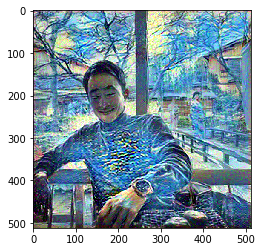

In [31]:
fig = plt.figure()
plt.imshow(final_img)